### Set up environment variables

In [16]:
! pip install matplotlib
! pip install s3fs
! pip install seaborn
! pip install yfinance
! pip install pyarrow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [4]:
import json
import os

# Load the credentials and connection information.
with open('credentials.json') as f:
    credentials = json.load(f)

os.environ['MINIO_URL'] = credentials['MINIO_URL']
os.environ['MINIO_ACCESS_KEY'] = credentials['MINIO_ACCESS_KEY']
os.environ['MINIO_SECRET_ACCESS_KEY'] = credentials['MINIO_SECRET_KEY']

### Downloading Market Data

In [18]:
import datetime
import yfinance as yf

start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)
download_dir = os.path.join(os.getcwd(), 'marketdata')

magnificient_seven = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
for ticker_string in magnificient_seven:
    ticker = yf.Ticker(ticker_string)
    historical_data = ticker.history(start=start_date, end=end_date)
    file_path = os.path.join(download_dir, f'{ticker_string}.parquet')
    historical_data.to_parquet(file_path)
    print(f'{ticker_string} downloaded.')

AAPL downloaded.
AMZN downloaded.
GOOGL downloaded.
META downloaded.
MSFT downloaded.
NVDA downloaded.
TSLA downloaded.


### Set up an S3 Connection

In [5]:
from s3fs import S3FileSystem
import os

key = os.environ['MINIO_ACCESS_KEY']
secret = os.environ['MINIO_SECRET_ACCESS_KEY']
endpoint_url = os.environ['MINIO_URL']

s3 = S3FileSystem(anon=False, endpoint_url=endpoint_url, 
                  key=key, 
                  secret=secret, 
                  use_ssl=True)

### Creating a Bucket

In [6]:
s3.ls('hugosbucket')

['hugosbucket/bunkhouse', 'hugosbucket/chat4bi.png']

In [8]:
bucket_name = 'market-data'
if not s3.exists(bucket_name):
    s3.makedir(f's3://{bucket_name}', exist_ok=True)

### Uploading Market Data

In [19]:
magnificient_seven = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
for ticker_string in magnificient_seven:
    local_file_path = os.path.join(download_dir, f'{ticker_string}.parquet')
    remote_object_path = f'{bucket_name}/{ticker_string}.parquet'
    s3.put_file(local_file_path, remote_object_path)
    print(f'{ticker_string} uploaded.')

AAPL uploaded.
AMZN uploaded.
GOOGL uploaded.
META uploaded.
MSFT uploaded.
NVDA uploaded.
TSLA uploaded.


### Listing Objects

In [9]:
object_list = s3.ls(f's3://{bucket_name}', detail=False)
object_list

['market-data/AAPL.parquet',
 'market-data/AMZN.parquet',
 'market-data/GOOGL.parquet',
 'market-data/META.parquet',
 'market-data/MSFT.parquet',
 'market-data/NVDA.parquet',
 'market-data/TSLA.parquet']

### Pandas DataFrame integration

In [10]:
import pandas as pd

ticker_string = 'NVDA'
storage_options={
    'key': key,
    'secret': secret,
    'endpoint_url': endpoint_url,
}
historical_data = pd.read_parquet(f's3://{bucket_name}/{ticker_string}.parquet', storage_options=storage_options)
historical_data.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-15 00:00:00-05:00,481.917410,494.016849,481.177454,488.877075,47947800,0.0,0.0
2023-12-18 00:00:00-05:00,493.976819,504.306321,491.476936,500.746490,41258700,0.0,0.0
2023-12-19 00:00:00-05:00,494.216820,496.976701,488.927090,496.016754,46444400,0.0,0.0
2023-12-20 00:00:00-05:00,496.526680,499.966521,480.957434,481.087402,39789400,0.0,0.0
2023-12-21 00:00:00-05:00,488.087090,490.926983,484.167291,489.877014,30042500,0.0,0.0
2023-12-22 00:00:00-05:00,491.926922,493.806808,484.647265,488.277069,25213900,0.0,0.0
2023-12-26 00:00:00-05:00,489.657037,495.976748,489.577054,492.766907,24420000,0.0,0.0
2023-12-27 00:00:00-05:00,495.086748,496.776671,490.826969,494.146820,23364800,0.0,0.0
2023-12-28 00:00:00-05:00,496.406712,498.816603,494.096823,495.196777,24658700,0.0,0.0


In [12]:
storage_options={
    'key': key,
    'secret': secret,
    'endpoint_url': endpoint_url,
}

magnificient_seven = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

df_list = []
for ticker_string in magnificient_seven:
    new_data = pd.read_parquet(f's3://{bucket_name}/{ticker_string}.parquet', storage_options=storage_options)
    new_data['Ticker'] = ticker_string
    df_list.append(new_data[['Ticker', 'Close']])

historical_data = pd.concat(df_list, axis=0)
historical_data[historical_data['Ticker']=='AMZN'].head()

,Ticker,Close
Date,,
2023-01-03 00:00:00-05:00,AMZN,85.820000
2023-01-04 00:00:00-05:00,AMZN,85.139999
2023-01-05 00:00:00-05:00,AMZN,83.120003
2023-01-06 00:00:00-05:00,AMZN,86.080002
2023-01-09 00:00:00-05:00,AMZN,87.360001


In [13]:
historical_data = historical_data.reset_index()
pt = historical_data.pivot(columns='Ticker', index='Date', values='Close')
pt.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-01-03 00:00:00-05:00,124.216293,85.820000,89.120003,124.607788,237.036011,143.079788,108.099998
2023-01-04 00:00:00-05:00,125.497498,85.139999,88.080002,127.235008,226.667282,147.417679,113.639999
2023-01-05 00:00:00-05:00,124.166641,83.120003,86.199997,126.805458,219.949371,142.580048,110.339996
2023-01-06 00:00:00-05:00,128.735245,86.080002,87.339996,129.882202,222.541565,148.517120,113.059998
2023-01-09 00:00:00-05:00,129.261627,87.360001,88.019997,129.332779,224.708298,156.203369,119.769997


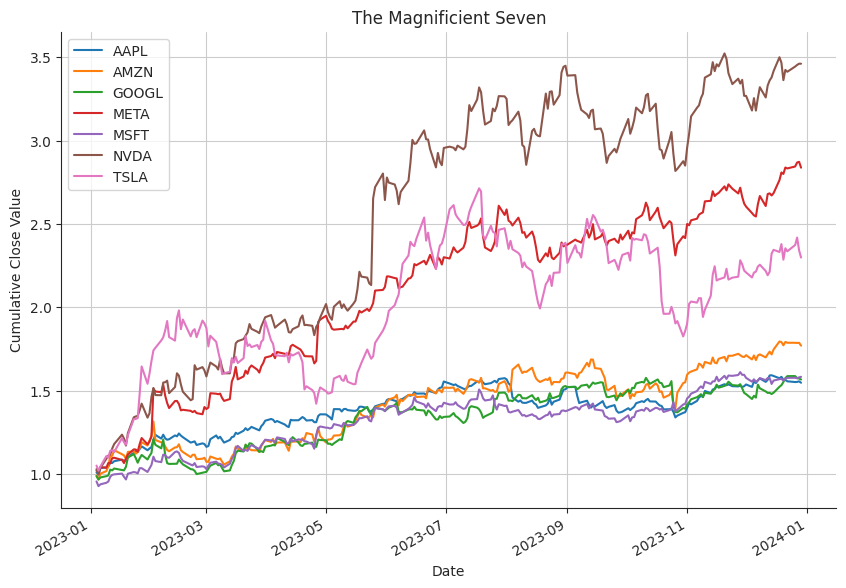

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn to set the style.
sns.set_style('ticks')

# Plot all the close prices as cumulutive closing values.
((pt.pct_change()+1).cumprod()).plot(figsize=(10, 7))
plt.legend()
plt.title('The Magnificient Seven')

# Define the labels
plt.ylabel('Cumulative Close Value')
plt.xlabel('Date')

# Plot the grid lines
plt.grid(True)
sns.despine()
plt.show()

In [ ]:
# Define the ticker list
import pandas as pd
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']

# Fetch the data
data = yf.download(tickers_list,'2023-1-1')['Adj Close']
data.head()

### Other methods of the yfinance Ticker object.

In [ ]:

msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="1mo")

# show meta information about the history (requires history() to be called first)
msft.history_metadata

# show actions (dividends, splits, capital gains)
msft.actions
msft.dividends
msft.splits
msft.capital_gains  # only for mutual funds & etfs

# show share count
msft.get_shares_full(start="2022-01-01", end=None)

# show financials:
# - income statement
msft.income_stmt
msft.quarterly_income_stmt
# - balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet
# - cash flow statement
msft.cashflow
msft.quarterly_cashflow
# see `Ticker.get_income_stmt()` for more options

# show holders
msft.major_holders
msft.institutional_holders
msft.mutualfund_holders
msft.insider_transactions
msft.insider_purchases
msft.insider_roster_holders

# show recommendations
msft.recommendations
msft.recommendations_summary
msft.upgrades_downgrades

# Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
msft.earnings_dates

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# show news
msft.news

# get option chain for specific expiration
opt = msft.option_chain('YYYY-MM-DD')
# data available via: opt.calls, opt.puts